# Problem 19: Application of a Groundwater Flow Model to a Water Supply Problem

In [63]:
#Import and modules/packages that we need to work with
%matplotlib inline
import os
import sys
import platform
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import flopy

In [221]:
#Store the values of each parameter into separate variables
inh = 0.0 #initial head
hk = 1.0 #hydraulic conductivity
s = 0.1 #storage coefficient
delr = 100 #grid spacing (uniform)
delc = delr
pr = -.963 #pumping rate ft^3/s (432 gpm)
perlen = 1.5 #stress period length in days
nstp = 10 #number of time steps
tsmult = 1.414 #time step multiplier
sip_it_par = 5 #SIP iteration parameters
mxiter = 50 #maximum number of iterations
accel_par = 1.0 #acceleration parameter
hclose = 0.001 #closure criterion (the head change criterion for convergence)
top = 0
botm = -1
nper = 1
laytyp = 1
ipakcb = 50

#grid 44 rows, 55 cols, 1 layer
nlay = 1 #number of layers
nrow = 44 #number of rows
ncol = 55 #number of columns

#pumping well (row 29, col 32)

#riv package
rstage = 0.0
rcond = .02
rbot = -10

In [222]:
#Flopy objects
modelname = 'p19' #short for problem 19
exe_name = '../MF2005.1_12/bin/mf2005.exe'
model_ws = 'temp'
mf = flopy.modflow.Modflow(modelname, exe_name=exe_name, model_ws = model_ws)

In [223]:
#call in the discretization package
dis = flopy.modflow.ModflowDis(mf, nlay, nrow, ncol, delr=delr, delc=delc,
                               top=top, botm=botm, nper=nper, perlen=perlen, 
                               nstp=nstp, tsmult=tsmult, steady=False)

In [224]:
#call in the basic package
ibound = np.ones((nlay, nrow, ncol))
strt = 0.0
bas = flopy.modflow.ModflowBas(mf, ibound=ibound, strt=strt)

In [225]:
#call in the layer-propery flow (LPF)
lpf = flopy.modflow.ModflowLpf(mf, hk=hk, sy=sy, laytyp=laytyp, ipakcb=ipakcb)


In [226]:
#call in the well package (WEL)
# Remember to use zero-based layer, row, column indices!
wel_sp1 = [[0, 27, 31, pr]]
wel_spd = {0: wel_sp1}
wel = flopy.modflow.ModflowWel(mf, stress_period_data=wel_spd)


In [227]:
#call in the preconditioned conjugate-gradient package (PCG) 
pcg = flopy.modflow.ModflowPcg(mf, mxiter=mxiter, hclose=hclose)


In [228]:
#call in the output control package (OC)
oc = flopy.modflow.ModflowOc(mf, stress_period_data={(0, 0): ['save head', 'print budget', 'save budget']})


In [229]:
#call in the river package (RIV)
#riv = flopy.modflow.ModflowRiv(mf, ipakcb=ipakcb, stress_period_data=riv_spd)

In [230]:
# Write the MODFLOW model input files
mf.write_input()

# Run the MODFLOW model
success, buff = mf.run_model()

FloPy is using the following executable to run the model: ../MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: p19.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2017/07/13 11:10:34

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:     8    Ground

In [231]:
import flopy.utils.binaryfile as bf

# Create the headfile object
fname = os.path.join(model_ws, 'p19.hds') #"os.path.join" joins together the modelname and the .hds file and stores it in fname
headobj = bf.HeadFile(fname) #create headobj and put values from fname (aka 'p1_pa.hds') inside it
times = headobj.get_times() #assign the headobj values to the variable "times"
print(times) #prints the time at each stress period

#print hydraulic head (Table 14.2)
idx = (0, 28, 31) #(nlay, nrow, ncol) *remember you have to subtract 1 from the original numbers for python - (1, 10, 12)*
ts = headobj.get_ts([idx])
print(ts)

[0.020063508, 0.048433311, 0.088548213, 0.14527068, 0.22547624, 0.33888692, 0.49924961, 0.72600245, 1.046631, 1.4999998]
[[  2.00635083e-02  -3.87588045e-10]
 [  4.84333113e-02  -1.71039072e-09]
 [  8.85482132e-02  -5.12933962e-09]
 [  1.45270675e-01  -1.30583020e-08]
 [  2.25476235e-01  -3.04528669e-08]
 [  3.38886917e-01  -6.73990499e-08]
 [  4.99249607e-01  -1.44300088e-07]
 [  7.26002455e-01  -3.02245724e-07]
 [  1.04663098e+00  -6.23696053e-07]
 [  1.49999976e+00  -1.27363660e-06]]


(0, 1.2736366e-06)

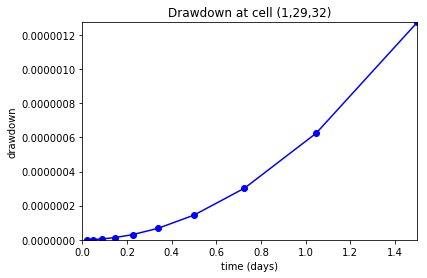

In [232]:
# Plot the drawdown versus time
plt.subplot(1, 1, 1)
ttl = 'Drawdown at cell ({0},{1},{2})'.format(idx[0] + 1, idx[1] + 1, idx[2] + 1) #we are adding 1 to each part of idx to that it prints out the real values and not the code values
plt.title(ttl) #prints/plots title
plt.xlabel('time (days)') #labels the x-axis
plt.ylabel('drawdown') #labels the y-axis
#here we do "0-ts..." in order to show the drawdown of 
plt.plot(ts[:, 0], 0-ts[:, 1], 'bo-') #(x, y, color/type of line)
plt.xlim(0, ts[:, 0].max())
plt.ylim(0, (0-ts[:, 1]).max())

(-1.2736366e-06, -3.8758804e-10)

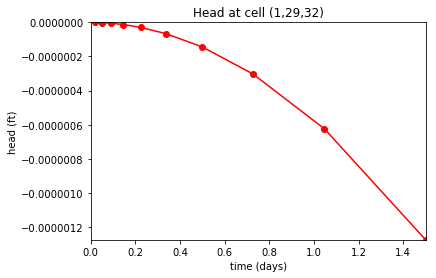

In [233]:
# Plot the head versus time
plt.subplot(1, 1, 1)
ttl = 'Head at cell ({0},{1},{2})'.format(idx[0] + 1, idx[1] + 1, idx[2] + 1)
plt.title(ttl)
plt.xlabel('time (days)')
plt.ylabel('head (ft)')
plt.plot(ts[:, 0], ts[:, 1], 'ro-')
plt.xlim(0, ts[:, 0].max())
plt.ylim(ts[:, 1].min(), ts[:, 1].max())

In [234]:
#create different variables for each well so that you can plot them
table2 = pd.read_csv('../Data/table19.2.csv')
print(table2)

well1=table2.ix[0:, ['Time (min)', 'Well 1']]
print(well1)

well2=table2.ix[0:, ['Time (min)', 'Well 2']]
print(well2)

well3=table2.ix[0:, ['Time (min)', 'Well 3']]
print(well3)

   Time (min)  Well 1  Well 2  Well 3
0           1    0.17    0.04    0.00
1           4    0.26    0.12    0.01
2          10    0.33    0.16    0.02
3          40    0.48    0.22    0.08
4         100    0.57    0.29    0.14
5         400    0.79    0.51    0.30
6        1000    0.99    0.70    0.50
7        2000    1.19    0.86    0.68
8        3000    1.33    0.98    0.78
   Time (min)  Well 1
0           1    0.17
1           4    0.26
2          10    0.33
3          40    0.48
4         100    0.57
5         400    0.79
6        1000    0.99
7        2000    1.19
8        3000    1.33
   Time (min)  Well 2
0           1    0.04
1           4    0.12
2          10    0.16
3          40    0.22
4         100    0.29
5         400    0.51
6        1000    0.70
7        2000    0.86
8        3000    0.98
   Time (min)  Well 3
0           1    0.00
1           4    0.01
2          10    0.02
3          40    0.08
4         100    0.14
5         400    0.30
6        1000    0.50
7   

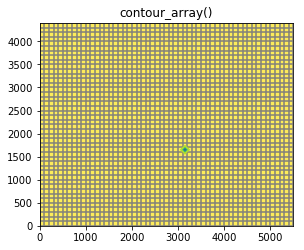

In [235]:
fname = os.path.join(modelname, 'p19.cbc')
head = headobj.get_data(totim=times[-1])
levels = np.linspace(head.min(), head.max(), 10)

fig = plt.figure(figsize=(10, 10))

#plot_array
ax = fig.add_subplot(1, 2, 1, aspect='equal')
ax.set_title('contour_array()')
modelmap = flopy.plot.ModelMap(model=mf)
quadmesh = modelmap.plot_ibound()
quadmesh = modelmap.plot_array(head, masked_values=[999.], alpha=0.5)
modelmap.plot_bc("WEL")
linecollection = modelmap.plot_grid()
contour_set = modelmap.contour_array(head, masked_values=[999.], levels=levels)



In [236]:
idx1 = (0, 27, 31) #(nlay, nrow, ncol) *remember you have to subtract 1 from the original numbers for python - (1, 10, 12)*
idx2 = (0, 28, 34)
idx3 = (0, 30, 31)
ts = headobj.get_ts([idx1, idx2, idx3])
print(ts)

[[  2.00635083e-02  -1.93196083e-05  -1.25183319e-23  -1.55996350e-19]
 [  4.84333113e-02  -4.66344354e-05  -2.11402189e-22  -1.75281309e-18]
 [  8.85482132e-02  -8.52514058e-05  -2.17852757e-21  -1.22614984e-17]
 [  1.45270675e-01  -1.39843425e-04  -1.78546661e-20  -6.91092593e-17]
 [  2.25476235e-01  -2.17011780e-04  -1.28566434e-19  -3.45216086e-16]
 [  3.38886917e-01  -3.26078385e-04  -8.54631377e-19  -1.60137646e-15]
 [  4.99249607e-01  -4.80199786e-04  -5.39354350e-18  -7.08140423e-15]
 [  7.26002455e-01  -6.97930169e-04  -3.28720351e-17  -3.03285127e-14]
 [  1.04663098e+00  -1.00540731e-03  -1.95589384e-16  -1.27069335e-13]
 [  1.49999976e+00  -1.43939466e-03  -1.14415135e-15  -5.24207414e-13]]


In [237]:
well_data=np.array(table2)
print(well_data)

[[  1.00000000e+00   1.70000000e-01   4.00000000e-02   0.00000000e+00]
 [  4.00000000e+00   2.60000000e-01   1.20000000e-01   1.00000000e-02]
 [  1.00000000e+01   3.30000000e-01   1.60000000e-01   2.00000000e-02]
 [  4.00000000e+01   4.80000000e-01   2.20000000e-01   8.00000000e-02]
 [  1.00000000e+02   5.70000000e-01   2.90000000e-01   1.40000000e-01]
 [  4.00000000e+02   7.90000000e-01   5.10000000e-01   3.00000000e-01]
 [  1.00000000e+03   9.90000000e-01   7.00000000e-01   5.00000000e-01]
 [  2.00000000e+03   1.19000000e+00   8.60000000e-01   6.80000000e-01]
 [  3.00000000e+03   1.33000000e+00   9.80000000e-01   7.80000000e-01]]


(0, 1.4999998)

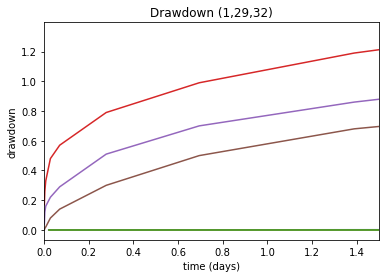

In [238]:
# Plot the drawdown versus time
plt.subplot(1, 1, 1)
ttl = 'Drawdown ({0},{1},{2})'.format(idx[0] + 1, idx[1] + 1, idx[2] + 1) #we are adding 1 to each part of idx to that it prints out the real values and not the code values
plt.title(ttl) #prints/plots title
plt.xlabel('time (days)') #labels the x-axis
plt.ylabel('drawdown') #labels the y-axis
#here we do "0-ts..." in order to show the drawdown of 
plt.plot(ts[:, 0], 0-ts[:, 1:]) #(x, y, color/type of line)
plt.plot(well_data[:, 0]/1440, well_data[:, 1:])
plt.xlim(0, ts[:, 0].max())
#plt.ylim(0, (0-ts[:, 1:]).max())



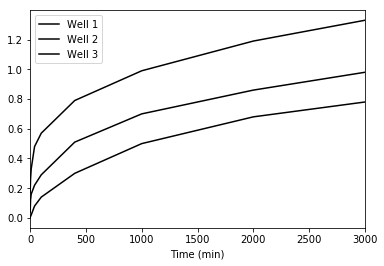

In [135]:
#create the index for the wells -> Time (min)
wells=table2.set_index(['Time (min)'])
wells.plot(color='k')
#plt.contour(wells)
plt.show()



<a list of 0 text.Text objects>

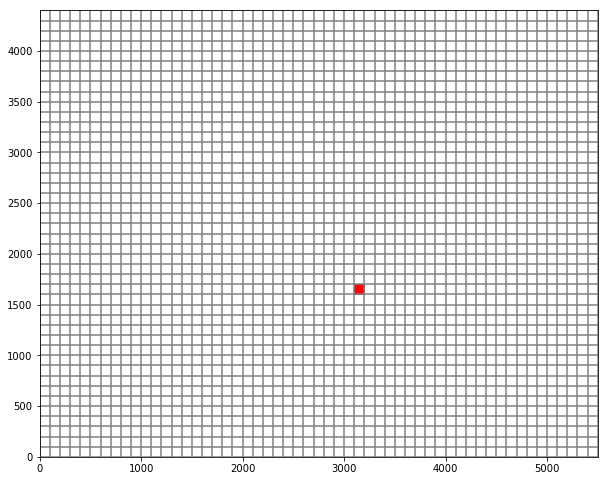

In [91]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
modelmap = flopy.plot.ModelMap(model=mf)
quadmesh = modelmap.plot_ibound()
linecollection = modelmap.plot_grid()
#riv = modelmap.plot_bc('RIV', color='b', plotAll=True)
quadmesh = modelmap.plot_bc('WEL', kper=1, plotAll=True)
contour_set = modelmap.contour_array(head, levels=np.arange(0, 36, 1), colors='g')
plt.clabel(contour_set, inline=1, fontsize=14)

In [47]:
fname = os.path.join(model_ws, 'p19.cbc')
cbb = flopy.utils.CellBudgetFile(fname)
frf = cbb.get_data(text='FLOW RIGHT FACE')
fff = cbb.get_data(text='FLOW FRONT FACE')

rflow = cbb.get_data(text='RIVER LEAKAGE') #create an array/for loop to get out first value of every step
#cbb.list_records()

#create new list
rlist=[]

#create for loop to store only the first value of each time step from riv_flow into riv_list
for riv in rflow:
    rlist.append(riv['q'][0])
    
print(rlist)

Exception: The specified text string is not in the budget file.

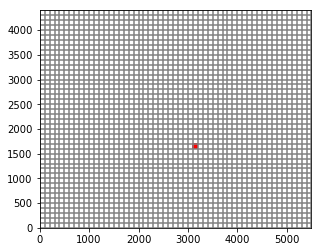

In [180]:
#create grid using model map
mm=flopy.plot.ModelMap(model=mf)
mm.plot_grid()
mm.plot_bc('WEL')

AttributeError: 'list' object has no attribute 'shape'

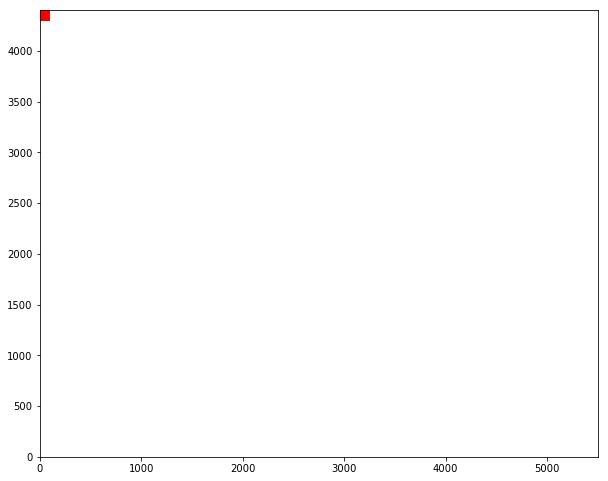

In [30]:
#plot arrows (quivers) that point in the direction of water flowb
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, aspect='equal')

modelmap = flopy.plot.ModelMap(model=mf)
modelmap.plot_bc("WEL")
quadmesh = modelmap.plot_ibound()
quiver = modelmap.plot_discharge(frf, fff, color='b')
linecollection = modelmap.plot_grid()

In [137]:
head

array([[[ 0.868595  ,  0.86857259,  0.86852735, ...,  0.86211669,
          0.86213088,  0.86213809],
        [ 0.86857772,  0.86855513,  0.86850965, ...,  0.86208355,
          0.8620981 ,  0.86210549],
        [ 0.86854368,  0.8685208 ,  0.86847484, ...,  0.86201733,
          0.86203277,  0.86204058],
        ..., 
        [ 0.86353415,  0.86348706,  0.86339289, ...,  0.8533935 ,
          0.85347909,  0.8535223 ],
        [ 0.86351991,  0.863473  ,  0.86337912, ...,  0.85339165,
          0.85347557,  0.85351801],
        [ 0.86351287,  0.86346602,  0.86337239, ...,  0.85339069,
          0.85347384,  0.8535158 ]]], dtype=float32)